In [25]:
!pip install -q ultralytics

In [26]:
import numpy as np 
import pandas as pd 
import os
import shutil
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
from sklearn.model_selection import train_test_split
from ultralytics import YOLO

In [27]:
animal_classes = {
    0: 'Заяц', 1: 'Кабан', 2: 'Кошки', 3: 'Куньи',
    4: 'Медведь', 5: 'Оленевые', 6: 'Пантеры',
    7: 'Полорогие', 8: 'Собачие', 9: 'Сурок'
}

In [28]:
dataset_df = pd.read_csv('/kaggle/input/where-are-the-animals/data_for_summer/train_split.csv')
df.head()

,image_name,detection,class
0,143a6e68a7a8233130523ee3a61500a0.JPG,4 0.4780943691730499 0.5708556771278381 0.3342...,4
1,da33b85db54db1045710aedfb8f0a26e.JPG,4 0.5346201062202454 0.6069518327713013 0.3259...,4
2,561cd359ad1707a1d80c2b73f78cd532.JPG,5 0.8759920001029968 0.5696250200271606 0.2480...,5
3,402e79a0ee09b9b4dec2e0fed8c98f99.JPG,1 0.021026235073804855 0.50728440284729 0.0420...,1
4,315b5c5348409ffcac36e0e6cfd605d7.JPG,2 0.46041667461395264 0.7762625813484192 0.407...,2


Визуализация примеров изображений с разметкой:


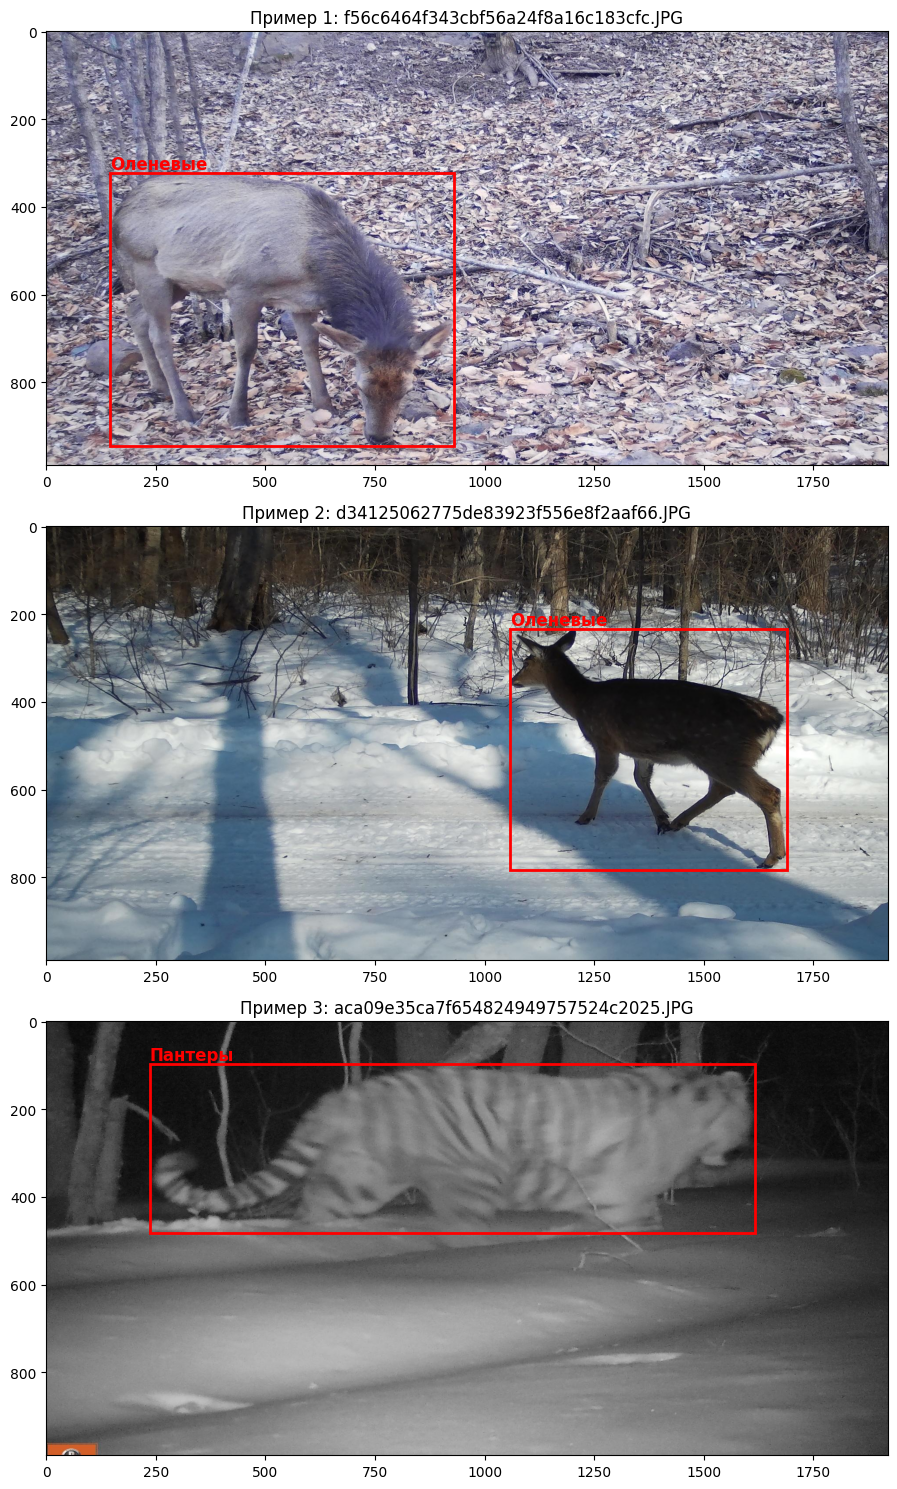

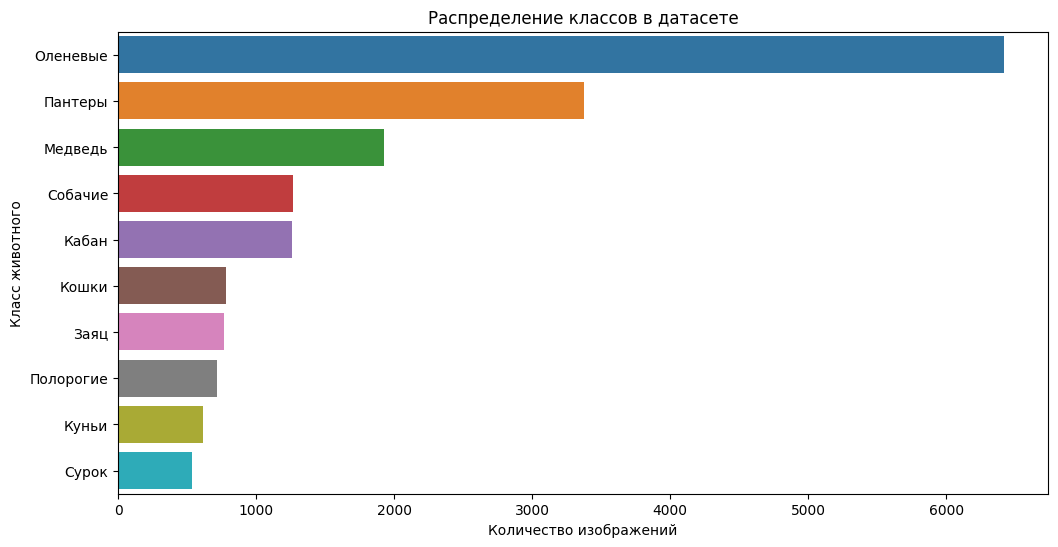

In [29]:
def show_examples_with_boxes(data, num_examples=3):
    plt.figure(figsize=(15, 5*num_examples))
    for i in range(num_examples):
        sample = data.sample(1).iloc[0]
        img_path = f"/kaggle/input/where-are-the-animals/data_for_summer/train/{sample['image_name']}"
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        plt.subplot(num_examples, 1, i+1)
        plt.imshow(img)
        plt.title(f"Пример {i+1}: {sample['image_name']}")
        
        if sample['detection'] != '-1':
            for detection in sample['detection'].split(';'):
                class_id, cx, cy, w, h = map(float, detection.split())
                rect = patches.Rectangle(
                    (cx*img.shape[1] - 0.5*w*img.shape[1], 
                     cy*img.shape[0] - 0.5*h*img.shape[0]),
                    w*img.shape[1], h*img.shape[0],
                    linewidth=2, edgecolor='red', facecolor='none'
                )
                plt.gca().add_patch(rect)
                plt.text(
                    cx*img.shape[1] - 0.5*w*img.shape[1],
                    cy*img.shape[0] - 0.5*h*img.shape[0] - 10,
                    f"{animal_classes[int(class_id)]}",
                    color='red', fontsize=12, weight='bold'
                )
    plt.tight_layout()
    plt.show()

# Визуализация нескольких примеров
print("Визуализация примеров изображений с разметкой:")
show_examples_with_boxes(dataset_df, 3)

# Анализ распределения классов
dataset_df['main_class'] = dataset_df['detection'].apply(
    lambda x: animal_classes[int(x.split(';')[0].split()[0])] if x != '-1' else 'No object'
)

plt.figure(figsize=(12, 6))
sns.countplot(data=dataset_df, y='main_class', order=dataset_df['main_class'].value_counts().index)
plt.title('Распределение классов в датасете')
plt.xlabel('Количество изображений')
plt.ylabel('Класс животного')
plt.show()

In [30]:
def prepare_yolov8_data(dataframe, source_img_dir, output_base_dir, mode='train'):
    img_dir = os.path.join(output_base_dir, 'images', mode)
    label_dir = os.path.join(output_base_dir, 'labels', mode)
    
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)
    
    for _, row in dataframe.iterrows():
        # Копирование изображений
        src_img = os.path.join(source_img_dir, row['image_name'])
        dst_img = os.path.join(img_dir, row['image_name'])
        shutil.copy(src_img, dst_img)
        
        # Создание аннотаций
        label_file = os.path.join(label_dir, row['image_name'].replace('.JPG', '.txt'))
        
        if row['detection'] == '-1':
            open(label_file, 'w').close()  # Создаем пустой файл
        else:
            with open(label_file, 'w') as f:
                for obj in row['detection'].split(';'):
                    f.write(obj.strip() + '\n')

# Разделение данных на train/val
train_data, val_data = train_test_split(
    dataset_df, 
    test_size=0.2, 
    random_state=42, 
    stratify=dataset_df['main_class']
)

# Подготовка директорий
dataset_dir = '/kaggle/working/yolov8_animals'
prepare_yolov8_data(train_data, 
                   '/kaggle/input/where-are-the-animals/data_for_summer/train',
                   dataset_dir, 'train')

prepare_yolov8_data(val_data,
                   '/kaggle/input/where-are-the-animals/data_for_summer/train',
                   dataset_dir, 'val')

# Создание конфигурационного файла
config = {
    'path': dataset_dir,
    'train': 'images/train',
    'val': 'images/val',
    'nc': len(animal_classes),
    'names': list(animal_classes.values())
}

In [ ]:
config_file = os.path.join(dataset_dir, 'animal_detection.yaml')
with open(config_file, 'w', encoding='utf-8') as f:
    yaml.dump(config, f, allow_unicode=True)

# Инициализация и обучение YOLOv8
detection_model = YOLO('yolov8s.pt')  # Используем pretrained YOLOv8 small

training_results = detection_model.train(
    data=config_file,
    epochs=10,
    batch=16,
    imgsz=640,
    augment=True,
    fliplr=0.5,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    optimizer='AdamW',
    lr0=0.001,
    name='animal_detection_yolov8'
)

Ultralytics 8.3.153 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolov8_animals/animal_detection.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=animal_detection_yolov82, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspe

train: Scanning /kaggle/working/yolov8_animals/labels/train.cache... 14129 images, 0 backgrounds, 0 corrupt: 100%|██████████| 14129/14129 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 873.8±435.8 MB/s, size: 257.6 KB)


val: Scanning /kaggle/working/yolov8_animals/labels/val.cache... 3533 images, 0 backgrounds, 0 corrupt: 100%|██████████| 3533/3533 [00:00<?, ?it/s]


Plotting labels to runs/detect/animal_detection_yolov82/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/animal_detection_yolov82
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      4.18G       1.07      4.234      1.278         19        640:  12%|█▏        | 109/884 [00:31<03:49,  3.38it/s]

In [33]:
# Визуализация результатов обучения
plt.figure(figsize=(12, 8))
metrics = ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
for metric in metrics:
    plt.plot(training_results.results_df[metric], label=metric)
plt.title('Метрики обучения YOLOv8')
plt.xlabel('Эпоха')
plt.ylabel('Значение метрики')
plt.legend()
plt.grid()
plt.show()

AttributeError: 'DetMetrics' object has no attribute 'results_df'. See valid attributes below.

    Utility class for computing detection metrics such as precision, recall, and mean average precision (mAP).

    Attributes:
        save_dir (Path): A path to the directory where the output plots will be saved.
        plot (bool): A flag that indicates whether to plot precision-recall curves for each class.
        names (Dict[int, str]): A dictionary of class names.
        box (Metric): An instance of the Metric class for storing detection results.
        speed (Dict[str, float]): A dictionary for storing execution times of different parts of the detection process.
        task (str): The task type, set to 'detect'.
    

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Предсказание на тестовых данных
test_results = detection_model.predict(
    '/kaggle/input/where-are-the-animals/data_for_summer/test',
    conf=0.25,
    save=True,
    save_txt=True,
    save_conf=True
)

In [ ]:

# Подготовка submission файла
def prepare_submission(predictions):
    submission_data = []
    for pred in predictions:
        image_name = os.path.basename(pred.path)
        if len(pred.boxes) == 0:
            submission_data.append([image_name, '-1'])
        else:
            detections = []
            for box in pred.boxes:
                class_id = int(box.cls)
                coords = ' '.join(f'{coord:.6f}' for coord in box.xywhn[0].tolist())
                confidence = f'{box.conf.item():.6f}'
                detections.append(f"{class_id} {coords} {confidence}")
            submission_data.append([image_name, ';'.join(detections)])
    return pd.DataFrame(submission_data, columns=['image_name', 'predicted_detection'])

final_submission = prepare_submission(test_results)
final_submission.to_csv('solve.csv', index=False)
print("GG")